In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### Funciones Externas

In [2]:
def atipicosAmissing(varaux):    
    # Verifica si la distribución de los datos es simétrica o asimétrica
    if abs(varaux.skew()) < 1:
        # Si es simétrica, calcula los valores atípicos basados en la desviación estándar
        criterio1 = abs((varaux - varaux.mean()) / varaux.std()) > 3
    else:
        # Si es asimétrica, calcula la Desviación Absoluta de la Mediana (MAD) y los valores atípicos
        mad = sm.robust.mad(varaux, axis=0)
        criterio1 = abs((varaux - varaux.median()) / mad) > 8
    
    # Calcula los cuartiles 1 (Q1) y 3 (Q3) para determinar el rango intercuartílico (H)
    qnt = varaux.quantile([0.25, 0.75]).dropna()
    Q1 = qnt.iloc[0]
    Q3 = qnt.iloc[1]
    H = 3 * (Q3 - Q1)
    
    # Identifica valores atípicos que están fuera del rango intercuartílico
    criterio2 = (varaux < (Q1 - H)) | (varaux > (Q3 + H))
    
    # Crea una copia de la serie original y reemplaza los valores atípicos por NaN
    var = varaux.copy()
    var[criterio1 & criterio2] = np.nan
    
    # Retorna la serie con valores atípicos reemplazados y el número de valores atípicos identificados
    return [var, sum(criterio1 & criterio2)]

In [3]:
def analizar_variables_categoricas(datos):
    # Inicializar un diccionario para almacenar los resultados
    resultados = {}
    
    # Genera una lista con los nombres de las variables.
    variables = list(datos.columns) 
    
    # Seleccionar las columnas numéricas en el DataFrame
    numericas = datos.select_dtypes(include=['int', 'int32', 'int64','float', 'float32', 'float64']).columns

    # Seleccionar las columnas categóricas en el DataFrame
    categoricas = [variable for variable in variables if variable not in numericas]
    
    # Iterar a través de las variables categóricas
    for categoria in categoricas:
        # Verificar si la variable categórica existe en el DataFrame
        if categoria in datos.columns:
            # Crear un DataFrame de resumen para la variable categórica
            resumen = pd.DataFrame({
                'n': datos[categoria].value_counts(),             # Conteo de frecuencias
                '%': datos[categoria].value_counts(normalize=True)  # Porcentaje de frecuencias
            })
            resultados[categoria] = resumen  # Almacenar el resumen en el diccionario
        else:
            # Si la variable no existe en los datos, almacenar None en el diccionario
            resultados[categoria] = None
    
    return resultados

# Data Exploration

In [4]:
data = pd.read_csv('house_prices.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


In [5]:
data.dtypes

longitude             float64
latitude              float64
housing_median_age      int64
total_rooms             int64
total_bedrooms        float64
population              int64
households              int64
median_income         float64
ocean_proximity        object
median_house_value      int64
dtype: object

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

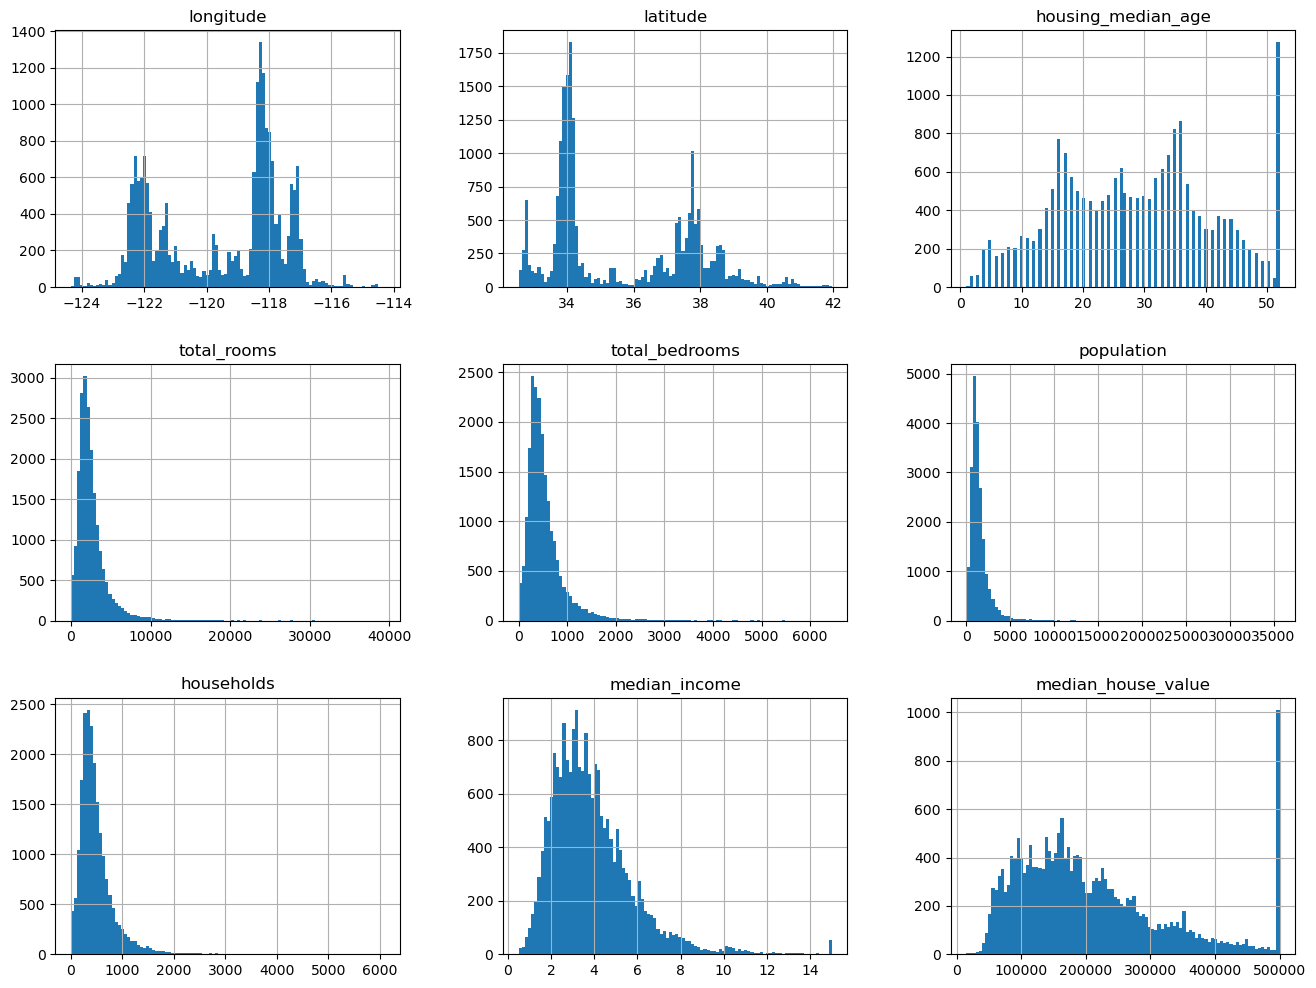

In [7]:
data.hist(bins=100, figsize=(16, 12))

## Delete extreme values

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

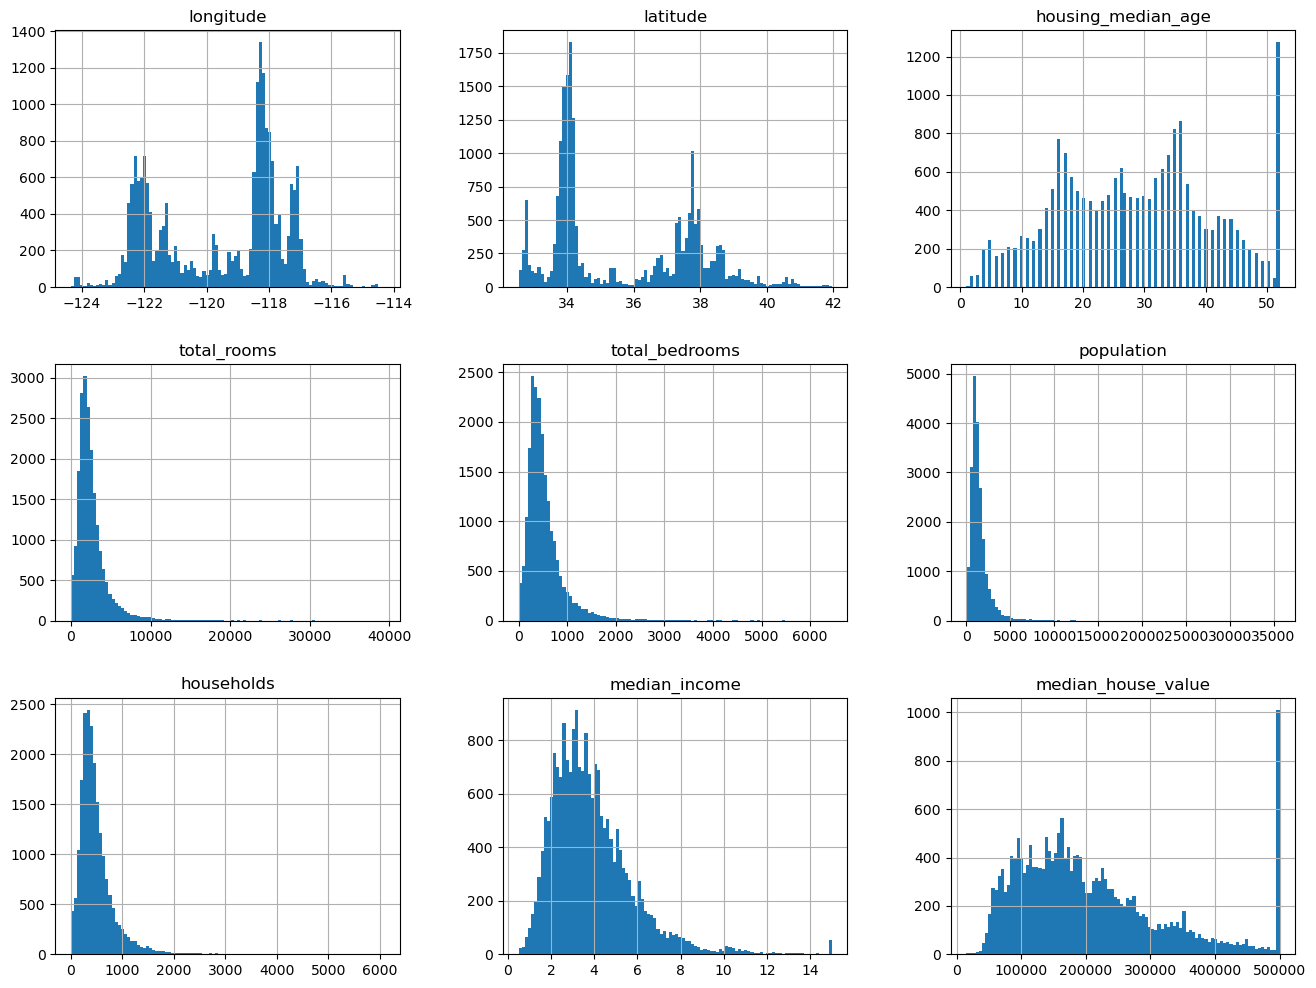

In [8]:
#data = data[data['median_house_value'] != 500001.0000]
#data = data[data['housing_median_age'] != 52]
data.hist(bins=100, figsize=(16, 12))

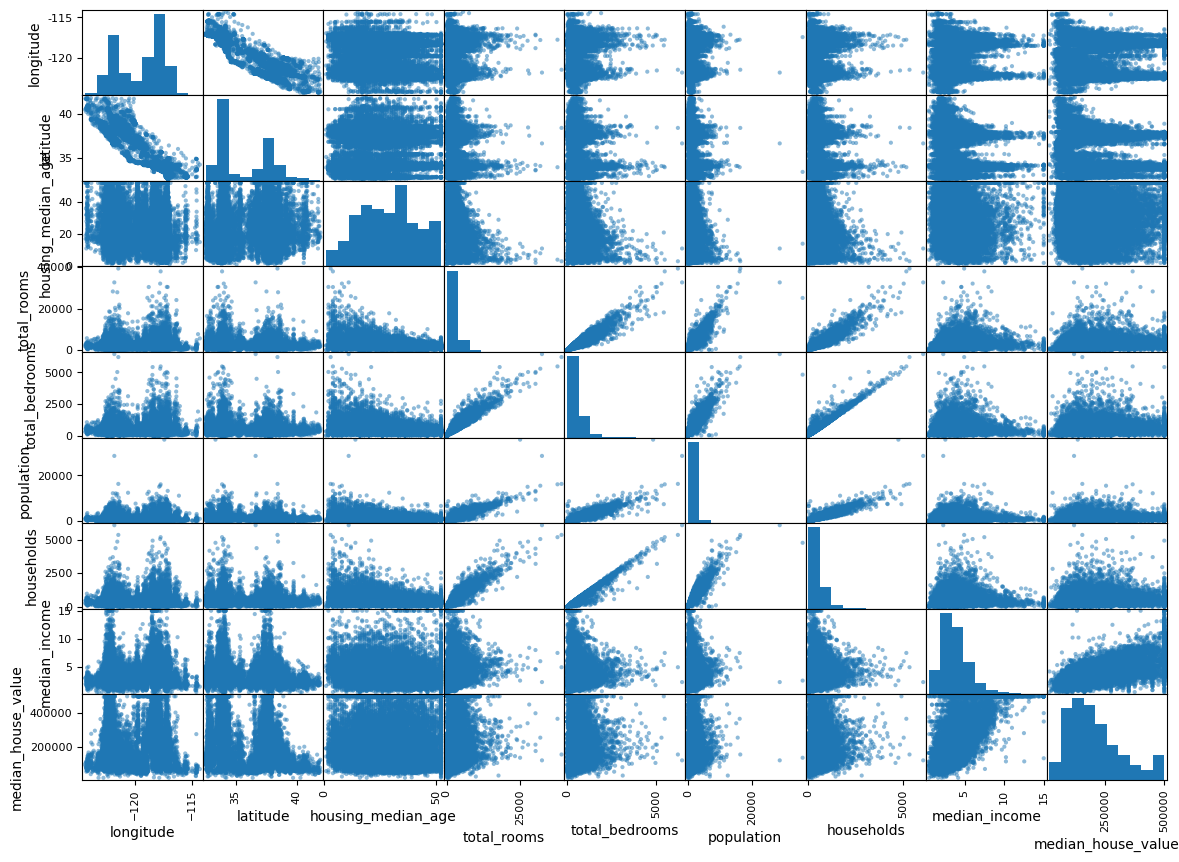

In [9]:
pd.plotting.scatter_matrix(data, figsize=(14,10))
plt.show()

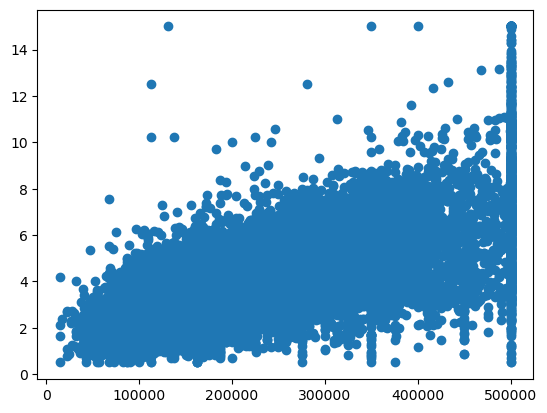

In [10]:
plt.scatter(data['median_house_value'], data['median_income'])

<Axes: >

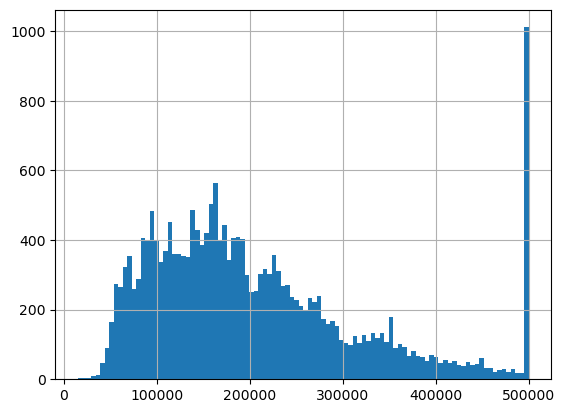

In [11]:
data['median_house_value'].hist(bins=100)

<Axes: >

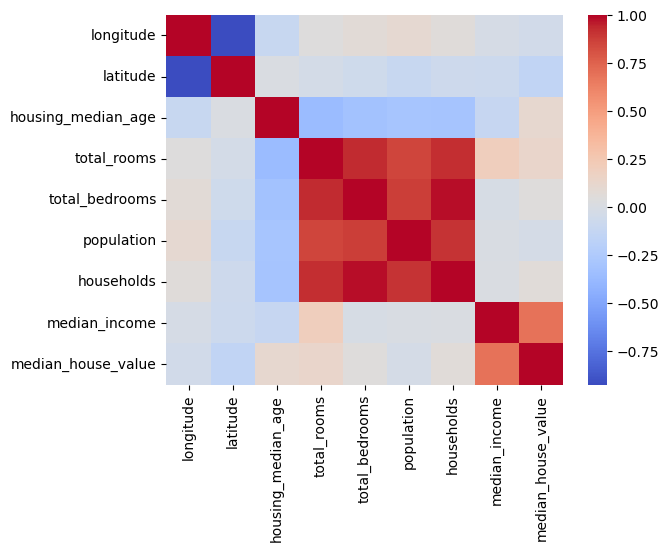

In [12]:
corr_vars = data.drop('ocean_proximity', axis=1)
sns.heatmap(corr_vars.corr(), cmap='coolwarm')

In [13]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

In [14]:
missing_counts = data.groupby('ocean_proximity')['total_rooms'].apply(lambda x: x.isna().sum())
missing_counts

ocean_proximity
<1H OCEAN     0
INLAND        0
ISLAND        0
NEAR BAY      0
NEAR OCEAN    0
Name: total_rooms, dtype: int64

In [15]:
data.shape

(20640, 10)

In [16]:
analizar_variables_categoricas(data)

{'ocean_proximity':                     n         %
 ocean_proximity                
 <1H OCEAN        9136  0.442636
 INLAND           6551  0.317393
 NEAR OCEAN       2658  0.128779
 NEAR BAY         2290  0.110950
 ISLAND              5  0.000242}

In [17]:
ocean_prox = data.groupby('ocean_proximity')['median_house_value'].mean()
ocean_prox

ocean_proximity
<1H OCEAN     240084.285464
INLAND        124805.392001
ISLAND        380440.000000
NEAR BAY      259212.311790
NEAR OCEAN    249433.977427
Name: median_house_value, dtype: float64

# Transform categorical data

In [18]:
data['ocean_proximity'] = data['ocean_proximity'].replace({"<1H OCEAN" : "NEAR_OCEAN", "INLAND" : "INLAND", "NEAR OCEAN" : "NEAR_OCEAN", "NEAR BAY" : "NEAR_OCEAN", "ISLAND" : "NEAR_OCEAN"})

In [19]:
analizar_variables_categoricas(data)

{'ocean_proximity':                      n         %
 ocean_proximity                 
 NEAR_OCEAN       14089  0.682607
 INLAND            6551  0.317393}

In [20]:
ocean_prox = data.groupby('ocean_proximity')['median_house_value'].mean()
ocean_prox


ocean_proximity
INLAND        124805.392001
NEAR_OCEAN    245007.022358
Name: median_house_value, dtype: float64

# Handle outliers

In [21]:
num_vars = data.select_dtypes(['int', 'float'])
[atipicosAmissing(data[x])[1] / len(data[x]) for x in num_vars]

[0.0,
 0.0,
 0.0,
 0.009399224806201551,
 0.0,
 0.007751937984496124,
 0.007461240310077519,
 0.0,
 0.0]

In [22]:
for x in num_vars:
    data[x] = atipicosAmissing(data[x])[0]


In [23]:
[atipicosAmissing(data[x])[1] / len(data[x]) for x in num_vars]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Drop missing values

In [24]:
data = data.dropna()
data.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
median_house_value    0
dtype: int64

In [25]:
data.shape

(20189, 10)

# Train test split

In [26]:
y = data['median_house_value']
X = data.drop('median_house_value', axis=1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=31254)

In [28]:
X_test.shape

(4038, 9)

In [29]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
11012,-117.83,33.77,22,2956.0,642.0,1342.0,558.0,4.1151,NEAR_OCEAN
15745,-122.43,37.78,52,4014.0,1069.0,2070.0,927.0,2.8202,NEAR_OCEAN
18784,-122.36,40.48,21,2333.0,514.0,1308.0,509.0,2.0899,INLAND
17000,-122.26,37.56,23,7283.0,1342.0,3399.0,1298.0,5.6683,NEAR_OCEAN
152,-122.23,37.80,52,2033.0,486.0,787.0,459.0,3.1603,NEAR_OCEAN


# New Variables

In [30]:
rooms_house = X_train['total_rooms'] / X_train['households']
bedrooms_house = X_train['total_bedrooms'] / X_train['households']
population_rooms = X_train['population'] / X_train['total_rooms']

df_rooms_house = pd.DataFrame(rooms_house, columns=['rooms_house'])
df_bedrooms_house = pd.DataFrame(bedrooms_house, columns=['bedrooms_house'])
df_population_rooms = pd.DataFrame(population_rooms, columns=['population_rooms'])
X_train = pd.concat([X_train, df_rooms_house, df_bedrooms_house, df_population_rooms], axis=1)

In [31]:
X_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_house,bedrooms_house,population_rooms
count,16151.000000,16151.000000,16151.000000,16151.000000,16151.000000,16151.000000,16151.000000,16151.000000,16151.000000,16151.000000,16151.000000
mean,-119.575029,35.639181,28.787567,2481.157266,508.930964,1350.853755,473.261594,3.856941,5.430098,1.098077,0.600726
std,2.002769,2.136951,12.524705,1630.701113,328.413931,864.744537,299.305260,1.899906,2.602191,0.500621,0.965107
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.846154,0.333333,0.018109
25%,-121.800000,33.930000,18.000000,1436.000000,293.000000,781.000000,277.000000,2.544400,4.432307,1.005355,0.435451
50%,-118.500000,34.260000,29.000000,2103.000000,429.000000,1154.000000,404.000000,3.518700,5.221477,1.048327,0.517615
75%,-118.010000,37.720000,37.000000,3085.000000,636.000000,1694.500000,593.000000,4.736100,6.045171,1.099199,0.660471
max,-114.310000,41.920000,52.000000,11544.000000,2634.000000,6330.000000,2194.000000,15.000100,141.909091,34.066667,116.611111


In [32]:
X_train = X_train.reset_index()

# Data transformation

In [33]:
num_vars = X_train.select_dtypes(['int', 'float']).columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train[num_vars])
scaled_data

array([[ 0.11725923,  0.87133484, -0.87472212, ..., -0.0509615 ,
         0.10479348, -0.15204379],
       [ 0.91137935, -1.42555578,  1.00184092, ..., -0.42273437,
         0.11007644, -0.08810776],
       [ 1.42127393, -1.3906031 ,  2.26536217, ..., -0.32535188,
        -0.1762952 , -0.04152448],
       ...,
       [-0.6562235 ,  0.77646327, -0.70157291, ..., -0.00693213,
         0.38629207, -0.16257812],
       [ 0.68940155,  1.17092927, -1.32865383, ..., -0.60775053,
        -0.08922203, -0.00250971],
       [-0.71914237,  0.916274  , -0.73901058, ..., -0.37707604,
        -0.01001144,  0.01845858]])

In [34]:
scaled_data.shape

(16151, 12)

In [35]:
num_df = pd.DataFrame(scaled_data, columns=["s_" + x for x in num_vars])


In [36]:

X_train = pd.concat([num_df, pd.DataFrame(X_train['ocean_proximity'])], axis=1)
X_train

,s_index,s_longitude,s_latitude,s_housing_median_age,s_total_rooms,s_total_bedrooms,s_population,s_households,s_median_income,s_rooms_house,s_bedrooms_house,s_population_rooms,ocean_proximity
0,0.117259,0.871335,-0.874722,-0.541951,0.291198,0.405199,-0.010239,0.283126,0.135884,-0.050962,0.104793,-0.152044,NEAR_OCEAN
1,0.911379,-1.425556,1.001841,1.853389,0.940019,1.705428,0.831654,1.516019,-0.545697,-0.422734,0.110076,-0.088108,NEAR_OCEAN
2,1.421274,-1.390603,2.265362,-0.621796,-0.090858,0.015435,-0.049558,0.119408,-0.930096,-0.325352,-0.176295,-0.041524,INLAND
3,1.121948,-1.340671,0.898887,-0.462106,2.944740,2.536722,2.368572,2.755595,0.953424,0.069498,-0.128203,-0.138872,NEAR_OCEAN
4,-1.704871,-1.325691,1.011200,1.853389,-0.274833,-0.069826,-0.652067,-0.047650,-0.366682,-0.384651,-0.078413,-0.221343,NEAR_OCEAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16146,1.242584,-1.096002,0.791254,-1.579932,0.416302,-0.124636,0.374858,-0.010898,1.940871,0.497022,-0.204418,-0.073220,NEAR_OCEAN
16147,1.060203,-0.661590,-0.144688,-1.021019,-0.555090,-0.675787,-0.874105,-0.705862,-0.141559,0.224882,-0.005309,-0.231264,NEAR_OCEAN
16148,-0.656223,0.776463,-0.701573,0.416185,-0.861102,-0.767138,-1.009409,-0.916356,-0.644968,-0.006932,0.386292,-0.162578,INLAND
16149,0.689402,1.170929,-1.328654,-0.142728,-0.726187,-0.468725,-0.664788,-0.455274,-0.733028,-0.607751,-0.089222,-0.002510,NEAR_OCEAN


# One hot encoder

In [37]:
encoder = OneHotEncoder()
encoded_array = encoder.fit_transform(X_train[['ocean_proximity']]).toarray()
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['ocean_proximity']))
encoded_df

,ocean_proximity_INLAND,ocean_proximity_NEAR_OCEAN
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0
...,...,...
16146,0.0,1.0
16147,0.0,1.0
16148,1.0,0.0
16149,0.0,1.0


In [38]:
X_train = pd.concat([X_train, encoded_df], axis=1)
X_train = X_train.drop(['ocean_proximity', 's_index'], axis=1)
X_train

,s_longitude,s_latitude,s_housing_median_age,s_total_rooms,s_total_bedrooms,s_population,s_households,s_median_income,s_rooms_house,s_bedrooms_house,s_population_rooms,ocean_proximity_INLAND,ocean_proximity_NEAR_OCEAN
0,0.871335,-0.874722,-0.541951,0.291198,0.405199,-0.010239,0.283126,0.135884,-0.050962,0.104793,-0.152044,0.0,1.0
1,-1.425556,1.001841,1.853389,0.940019,1.705428,0.831654,1.516019,-0.545697,-0.422734,0.110076,-0.088108,0.0,1.0
2,-1.390603,2.265362,-0.621796,-0.090858,0.015435,-0.049558,0.119408,-0.930096,-0.325352,-0.176295,-0.041524,1.0,0.0
3,-1.340671,0.898887,-0.462106,2.944740,2.536722,2.368572,2.755595,0.953424,0.069498,-0.128203,-0.138872,0.0,1.0
4,-1.325691,1.011200,1.853389,-0.274833,-0.069826,-0.652067,-0.047650,-0.366682,-0.384651,-0.078413,-0.221343,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16146,-1.096002,0.791254,-1.579932,0.416302,-0.124636,0.374858,-0.010898,1.940871,0.497022,-0.204418,-0.073220,0.0,1.0
16147,-0.661590,-0.144688,-1.021019,-0.555090,-0.675787,-0.874105,-0.705862,-0.141559,0.224882,-0.005309,-0.231264,0.0,1.0
16148,0.776463,-0.701573,0.416185,-0.861102,-0.767138,-1.009409,-0.916356,-0.644968,-0.006932,0.386292,-0.162578,1.0,0.0
16149,1.170929,-1.328654,-0.142728,-0.726187,-0.468725,-0.664788,-0.455274,-0.733028,-0.607751,-0.089222,-0.002510,0.0,1.0


# Transform test_data

In [39]:
def transform_test(X_test):
    X_test = X_test.reset_index()    
    # Create new variables
    rooms_house = X_test['total_rooms'] / X_test['households']
    bedrooms_house = X_test['total_bedrooms'] / X_test['households']
    population_rooms = X_test['population'] / X_test['total_rooms']

    df_rooms_house = pd.DataFrame(rooms_house, columns=['rooms_house'])
    df_bedrooms_house = pd.DataFrame(bedrooms_house, columns=['bedrooms_house'])
    df_population_rooms = pd.DataFrame(population_rooms, columns=['population_rooms'])

    X_test = pd.concat([X_test, df_rooms_house, df_bedrooms_house, df_population_rooms], axis=1)
    
    # Transform categorical
    X_test['ocean_proximity'] = X_test['ocean_proximity'].replace({"<1H OCEAN" : "NEAR_OCEAN", "INLAND" : "INLAND", "NEAR OCEAN" : "NEAR_OCEAN", "NEAR BAY" : "NEAR_OCEAN", "ISLAND" : "NEAR_OCEAN"})
    
    # Scale numerical data
    num_vars = X_test.select_dtypes(['int', 'float']).columns
    scaled_data = scaler.fit_transform(X_test[num_vars])
    num_df = pd.DataFrame(scaled_data, columns=["s_" + x for x in num_vars])
    
    # replace scaled data
    X_test = pd.concat([num_df, pd.DataFrame(X_test['ocean_proximity'])], axis=1)
    
    # Transform categorical    
    
    # OneHotEncoding
    encoded_array = encoder.fit_transform(X_test[['ocean_proximity']]).toarray()
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['ocean_proximity']))
    X_test = pd.concat([X_test, encoded_df], axis=1)
    X_test = X_test.drop(['ocean_proximity', 's_index'], axis=1)
    return X_test
X_test = transform_test(X_test)

# Prediction test

In [40]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
prediction = lin_reg.predict(X_test)
prediction

array([ 68098.01121932,  99008.59545067, 141791.94480513, ...,
       320554.38048792, 258776.8423636 , 149577.56975109])

In [41]:
mse = mean_absolute_error(y_test, prediction)
me = mean_squared_error(y_test, prediction, squared=False)
r2 = r2_score(y_test, prediction)
print(mse)
print(me)
print(r2)

48679.58919446232
66774.42592936313
0.6648809223929112
